In [1]:
import networkx as nx
import pylab as plt
import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from matplotlib.pyplot import figure
import statistics


In [2]:
PR_df = pd.read_csv('./PR_df.csv')
PR_df.sort_values(by='0',inplace = True, ascending=False)
PR_df.reset_index(drop = True, inplace = True)
PR_df.rename(columns={'Unnamed: 0':'Author', '0':'PR_values'}, inplace = True)
PR_df.head()

,Author,PR_values
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.042414
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.015953
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014931
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014887
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014411


In [3]:
DB_AA_originale = pd.read_csv('./DB_articles_authors_built.csv')


#genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
#DB_AA_originale = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
DB_AA_originale.head()

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
0,bea8b41266f68383aab0ab6f11e1423db72df15ff8357a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
1,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
2,e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
3,f2b1c07718734fb4f48789faef537bc69604b53befe340...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
4,c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available


In [4]:
DB_AA_originale.FromNodeId.nunique()

1066

In [5]:
DB_AA_originale.ToNodeId.nunique()

663

In [6]:
#load the msg_DB from file 
def readMsgDB():
    print('Checking for local message_id stored...\n')
    try: 
        file = open("lista_msgDB.txt", "r")
        msg_DB = file.readlines()

        for i in range(len(msg_DB)):
            msg_DB[i] = msg_DB[i].replace("\n", "")

        print(f'Found #{len(msg_DB)} messages from the file lista_msgDB.txt \n')

        file.close() 
    except:
        
        msg_DB = []

    
    return msg_DB

msg_DB = readMsgDB()

Checking for local message_id stored...

Found #1066 messages from the file lista_msgDB.txt 



In [7]:
#load the DF containing the communities found
Communities = pd.read_csv('./Best_Clusters_DF.csv')
Communities.sort_values(by='cluster_size',inplace = True)

Communities.reset_index(drop = True, inplace = True)

def replaceSlash(row):
    return row.replace('\\n','\n')

repS = np.vectorize(replaceSlash)

Communities.cluster_authors = repS(Communities.cluster_authors)

Communities

,cluster_authors,cluster_size
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
...,...,...
66,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,35
67,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,45
68,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,50
69,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,82


In [8]:
Communities.cluster_size.sum()

871

In [9]:
#Communities.index.values

In [10]:
#Costruisco grafo avente tanti nodi quante communities. Ogni arco a->b esiste <=> la community a contiene un 
#autore che cita un autore contenuto nella community b

num_nodi = len(Communities)


#GRAPH CREATION


#STAMPA GRAFO
D=nx.DiGraph()

for i in Communities.index.values:
    D.add_node(str(i),nodeId = str(i))
    
for i in Communities.index.values: 
    
    inner_authors = Communities.iloc[i]['cluster_authors'].split("*")
    
    for j in Communities.index.values:
        
        if(i!=j):
        
            outer_authors = Communities.iloc[j]['cluster_authors'].split("*")

            temp_df = DB_AA_originale[DB_AA_originale['From_Author_Pub_Key'].isin(inner_authors)]

            temp_df = temp_df[temp_df['To_Author_Pub_key'].isin(outer_authors)]

            #print(temp_df)

            if(len(temp_df) > 0):           

                D.add_weighted_edges_from([(str(i),str(j),len(temp_df))])


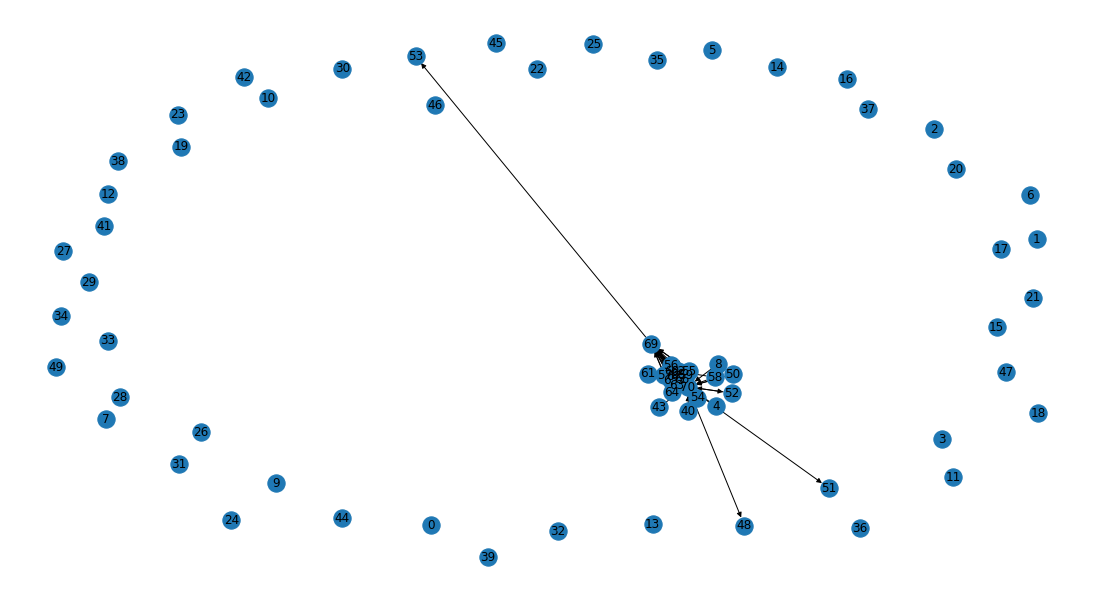

In [15]:
figure(figsize=(15,8))

nx.draw(D, with_labels=True)
plt.show()

In [16]:
#Poiche il dataset Communities ha, in ogni riga, gli autori separati dal carattere '*', 
#per rendere efficiente il calcolo in seguito, vengono splittati ora
Communities_splitted = pd.DataFrame(columns=['community','authors'])
Communities_splitted.community = range(0,len(Communities))
Communities_splitted.set_index('community',inplace = True)

lun = 0

for i in range(len(Communities)):
    autori = Communities.loc[i]['cluster_authors'].split("*")
    Communities_splitted.loc[i]['authors'] = autori
    lun += len(autori)
    
print(lun)
    


871


In [17]:
#Nelle due celle seguenti viene mostrata la differenza tra i due DF

In [17]:
Communities.iloc[0]['cluster_authors']

'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEA0dnd/2q1miceFJ4M/Hjo\nUGblGQjv0Slq9wPjlJpjD0qMzHFyct46l+gqfRYxVtoFEsQRqTLfj8CMcjJvn439\nxMlXByjnCXpI/y+SYHQNK+4STV/MnO5pr01B1ZDerHrBFcQu/IdKMhXwVBCb5gwP\nlzCeiP9Shw4I40rbU1zs593SBEPvQry681j210mbwge0TfkjDc4qCFJT5zACiQrB\nJzG86oankBgh/2X+Grlm8T4LlmVjvOajFAZsTwZta7HK3JX/a2z+OIdaaRwYwbkW\nQ17irPSo79E+Mczw7MzxRIIsegWGH/HzKRmgBLbVEN9fciAXcMoUzZuSRmjCKMwM\nHQIDAQAB\n-----END PUBLIC KEY-----\n*-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAtdv2ONOW6Csv8p1BK2Cg\nrQDP8koxz7h1ka2T/zw7opKQyyQljw63XCXwSVVKS5EtSKrBuQPWkM38uN98pvsW\nPevxUHBW+aueCjkLJBg46v7Ttu4NV0tOVMQT+ehyCQSzgma5guR3HO5QzrolwBK1\n9bSL4+8Tu5v993vQzuAKFuL7cP0WaD1iigmwCeP8JU6tBtX1HJ2Pi7IilGNC0q4T\nT1rAbSgmwqTGwWIVI52rMEbaddvhMyhdnQmg0XVrkRXX1dLe4skBCgCFz0U+YV63\nBlycRVrl7iFPJgOW/I4HRL+716Yg2Cldjo9Gifod/mGeyV8qlPBVkRStJsHFKWuc\nXQIDAQAB\n-----END PUBLIC KEY-----\n'

In [18]:
Communities_splitted.iloc[0]['authors']

['-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEA0dnd/2q1miceFJ4M/Hjo\nUGblGQjv0Slq9wPjlJpjD0qMzHFyct46l+gqfRYxVtoFEsQRqTLfj8CMcjJvn439\nxMlXByjnCXpI/y+SYHQNK+4STV/MnO5pr01B1ZDerHrBFcQu/IdKMhXwVBCb5gwP\nlzCeiP9Shw4I40rbU1zs593SBEPvQry681j210mbwge0TfkjDc4qCFJT5zACiQrB\nJzG86oankBgh/2X+Grlm8T4LlmVjvOajFAZsTwZta7HK3JX/a2z+OIdaaRwYwbkW\nQ17irPSo79E+Mczw7MzxRIIsegWGH/HzKRmgBLbVEN9fciAXcMoUzZuSRmjCKMwM\nHQIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAtdv2ONOW6Csv8p1BK2Cg\nrQDP8koxz7h1ka2T/zw7opKQyyQljw63XCXwSVVKS5EtSKrBuQPWkM38uN98pvsW\nPevxUHBW+aueCjkLJBg46v7Ttu4NV0tOVMQT+ehyCQSzgma5guR3HO5QzrolwBK1\n9bSL4+8Tu5v993vQzuAKFuL7cP0WaD1iigmwCeP8JU6tBtX1HJ2Pi7IilGNC0q4T\nT1rAbSgmwqTGwWIVI52rMEbaddvhMyhdnQmg0XVrkRXX1dLe4skBCgCFz0U+YV63\nBlycRVrl7iFPJgOW/I4HRL+716Yg2Cldjo9Gifod/mGeyV8qlPBVkRStJsHFKWuc\nXQIDAQAB\n-----END PUBLIC KEY-----\n']

In [19]:
#Creo il DF che conterrà la stima di veridicità calcolata per ogni articolo

stima_veridicita_articoli = pd.DataFrame(columns=['article_id','estimate'])
stima_veridicita_articoli['article_id'] = msg_DB
stima_veridicita_articoli.set_index('article_id',inplace = True)
stima_veridicita_articoli

,estimate
article_id,
bea8b41266f68383aab0ab6f11e1423db72df15ff8357a1a769b5f4005b39533,NaN
48f59e57815078456b89fe34932606fcf1e5fa7874cf00498999ed99247a73b1,NaN
e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08b259ca41eb31c8a358,NaN
f2b1c07718734fb4f48789faef537bc69604b53befe3402c7fe4cfd0f71ededb,NaN
c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd334c2dfd039e019a4d,NaN
...,...
642acd3957e86003df21148bec1f62cd6ecce16c7bab00fc9fcc5e766a0a2886,NaN
a90d93063f81d04b7b2b2a7ad70aa0a4ae1900c05d5328ecc5f1da486cbce44e,NaN
f1cb6682fae35ace95e977735bbe2976c10c1a77ed3b877b56aefc8a65ee9519,NaN


a[PR(auth_i)/PR_Max] + b[#cit_entranti_i/#cit_entranti_Max] + c[AVG(PR_auth_citano_i)/PR_Max] + d[Communities value]

In [69]:
#TEST FATTO IGNORANDO I WEIGHT TRA LE COMMUNITIES, CONSIDERO SOLO I #HOP


#Definisco i valori comuni necessari al calcolo

#PR normalization---
PR_Max = PR_df.query('PR_values == PR_values.max()')['PR_values'].values[0]
PR_Min = PR_df.query('PR_values == PR_values.min()')['PR_values'].values[0]
PR_Difference = PR_Max - PR_Min
PR_mean = PR_df.PR_values.mean()
PR_stdev = PR_df.PR_values.std()
#print(PR_Max)

#max_cit_entranti---
genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
DB_AA_originale_senza_genesis = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
res = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count()
cit_entranti_max = res.max()
cit_entranti_min = res.min()
cit_entranti_Difference = cit_entranti_max - cit_entranti_min
cit_entranti_mean = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().mean()
cit_entranti_stdev =DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().std()
#print(cit_entranti_max)

#max_len_#_hop---
path = dict(nx.all_pairs_dijkstra_path(D))
list_of_len = []
max_len = 0
min_len = len(D.nodes)
for node in D.nodes:
    for paths in path[node]:
        local_len = len(path[node][paths])-1
        list_of_len.append(local_len)
        if(local_len > max_len):
            max_len = local_len
        elif(local_len < min_len):
            min_len = local_len

max_len
min_len
len_Difference = max_len - min_len
mean_len = statistics.mean(list_of_len)
stdev_len = statistics.stdev(list_of_len)


a = 0.2
b = 0.2
c = 0.2
d = 0.4

In [29]:
#Fornito in input un set di ids delle communities che citano un articolo
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

def computeMinOfHopAvgDist(communities_citanti):
    
    if(len(communities_citanti)>0):
    
        min_avg_dist = max_len #init la distanza minore individuata finora al valore della distanza max
        for i in communities_citanti: #per ogni community citante

            local_avg_dist = 0

            for j in communities_citanti: #scandisco le altre communities citanti
                if(i!=j):
                    if(str(j) in path[str(i)]):
                        local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    else:
                        local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato

            local_avg_dist = local_avg_dist/len(communities_citanti) #calcolo media distanza tra la community e le altre

            if(local_avg_dist < min_avg_dist):
                min_avg_dist = local_avg_dist

        return min_avg_dist
    
    else:
        return 0

In [30]:
#Fornito in input un set di ids delle communities che citano un articolo
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

def computeAvgOfHopAvgDist(communities_citanti):
    
    if(len(communities_citanti)>0):
    
        avg_dist = 0 #init la distanza media
        for i in communities_citanti: #per ogni community citante

            local_avg_dist = 0

            for j in communities_citanti: #scandisco le altre communities citanti
                if(i!=j):
                    if(str(j) in path[str(i)]):
                        local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    else:
                        local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato

            local_avg_dist = local_avg_dist/len(communities_citanti) #calcolo media distanza tra la community e le altre

            avg_dist += local_avg_dist


        return avg_dist/len(communities_citanti)
    else:
        return 0

# NORMALIZZAZIONE FATTA DIVIDENDO PER MAX_VALUE

<AxesSubplot:xlabel='article_id'>

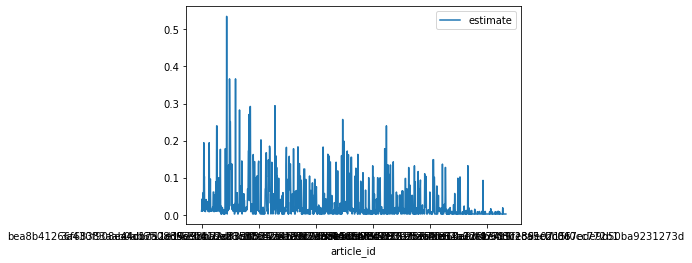

In [31]:
#DISTANZA TRA COMMUNITIES CON MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB: #per ogni articolo

    
    #individuo autore
    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    
    #individuo PR autore
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    
    #individuo num cit entranti
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    #individuo autori che lo citano
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0


    #calcolo la distanza media tra le communities che mi citano
    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)

    stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max) + d*(Min_of_hop_avg_dist/max_len)  
    
stima_veridicita_articoli.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x12fb1fd3a90>,
 'caps': [<matplotlib.lines.Line2D at 0x12faff66490>,
 'boxes': [<matplotlib.lines.Line2D at 0x12fb1fd3520>],
 'medians': [<matplotlib.lines.Line2D at 0x12faff66400>],
 'fliers': [<matplotlib.lines.Line2D at 0x12faff66340>],
 'means': []}

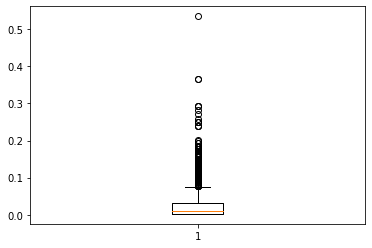

In [37]:
plt.boxplot(stima_veridicita_articoli.estimate)

<AxesSubplot:xlabel='article_id'>

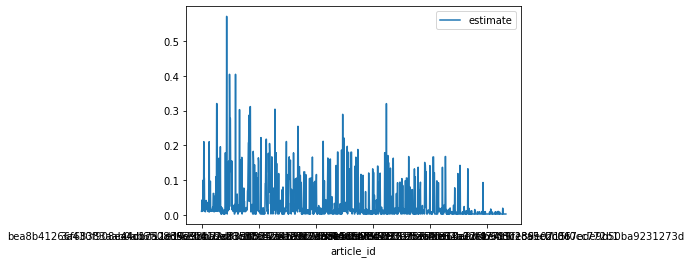

In [38]:
#DISTANZA TRA COMMUNITIES CON AVG OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB: #per ogni articolo

    
    #individuo autore
    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    
    #individuo PR autore
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    
    #individuo num cit entranti
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    #individuo autori che lo citano
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0


    #calcolo la distanza media tra le communities che mi citano
    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Avg_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_citanti)

    stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max) + d*(Avg_of_hop_avg_dist/max_len)  
    

    
stima_veridicita_articoli.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x12fab4600a0>,
 'caps': [<matplotlib.lines.Line2D at 0x12fab460550>,
 'boxes': [<matplotlib.lines.Line2D at 0x12fa85a3b50>],
 'medians': [<matplotlib.lines.Line2D at 0x12faa115ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12faa115460>],
 'means': []}

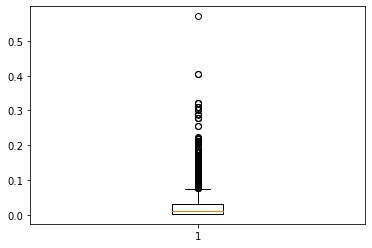

In [39]:
plt.boxplot(stima_veridicita_articoli.estimate)

# NORMALIZZAZIONE FATTA STANDARDIZZANDO OGNI VARIABILE IN BASE ALLA SUA DISTRIBUZIONE

<AxesSubplot:xlabel='article_id'>

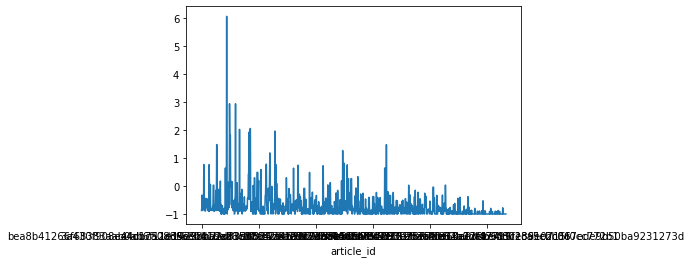

In [40]:
#NORMALIZZAZIONE FATTA TRAMITE STANDARDIZZAZIONE DEI VALORI

#MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)
    
    
    
    stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_mean)/PR_stdev) + b*((num_cit_entranti-cit_entranti_mean)/cit_entranti_stdev) + c*((AVG_PR_autori_citanti-PR_mean)/PR_stdev) + d*((Min_of_hop_avg_dist-mean_len)/stdev_len)  
    
    
stima_veridicita_articoli.estimate.plot()    

<AxesSubplot:xlabel='article_id'>

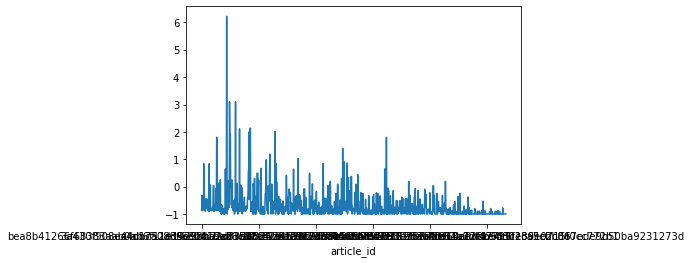

In [41]:
#NORMALIZZAZIONE FATTA TRAMITE STANDARDIZZAZIONE DEI VALORI

#MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Avg_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_citanti)
    
    
    
    stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_mean)/PR_stdev) + b*((num_cit_entranti-cit_entranti_mean)/cit_entranti_stdev) + c*((AVG_PR_autori_citanti-PR_mean)/PR_stdev) + d*((Avg_of_hop_avg_dist-mean_len)/stdev_len)  
    
    
stima_veridicita_articoli.estimate.plot()    

# NORMALIZZAZIONE FATTA CON MINMAX DOPO IL CALCOLO COMPLETO

In [42]:
#NORMALIZZAZIONE MINMAX FATTA DOPO IL CALCOLO COMPLETO, CHE QUINDI VIENE SVOLTO SENZA NORMALIZZAZIONI

#MIN OF AVG
stima = []

for m in msg_DB:


#print(article_id)

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)

    stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) + d*(Min_of_hop_avg_dist)  

<AxesSubplot:xlabel='article_id'>

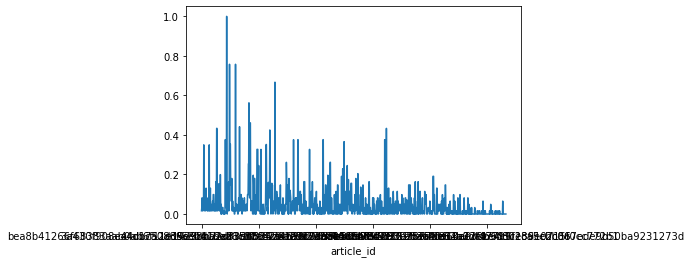

In [43]:
#X_normalized = (X - X_min) / (X_max - X_min)
min_val = stima_veridicita_articoli.estimate.min()
max_val = stima_veridicita_articoli.estimate.max()
max_minus_min = max_val - min_val

stima_veridicita_articoli['estimate'] = stima_veridicita_articoli['estimate'].apply(lambda row: (row - min_val)/max_minus_min)
stima_veridicita_articoli.estimate.plot()

In [44]:
#NORMALIZZAZIONE MINMAX FATTA DOPO IL CALCOLO COMPLETO, CHE QUINDI VIENE SVOLTO SENZA NORMALIZZAZIONI

#AVG OF AVG
stima = []

for m in msg_DB:


#print(article_id)

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Avg_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_citanti)

    stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) + d*(Avg_of_hop_avg_dist)  

<AxesSubplot:xlabel='article_id'>

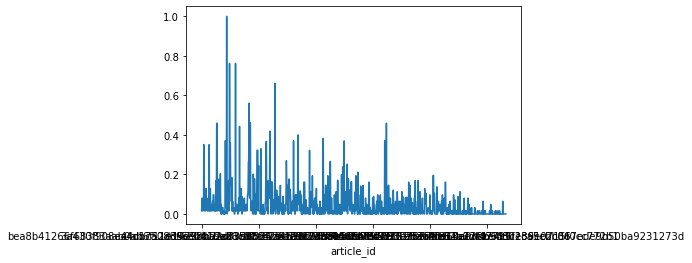

In [45]:
#X_normalized = (X - X_min) / (X_max - X_min)
min_val = stima_veridicita_articoli.estimate.min()
max_val = stima_veridicita_articoli.estimate.max()
max_minus_min = max_val - min_val

stima_veridicita_articoli['estimate'] = stima_veridicita_articoli['estimate'].apply(lambda row: (row - min_val)/max_minus_min)
stima_veridicita_articoli.estimate.plot()

# NORMALIZZAZIONE FATTA CON MIN MAX SU OGNI VARIABILE IN BASE ALLA SUA DISTRIBUZIONE

<AxesSubplot:xlabel='article_id'>

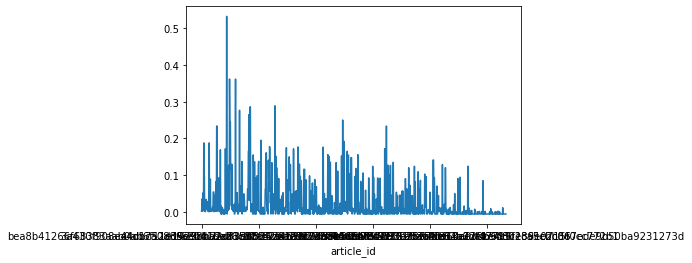

In [73]:


#MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)
    
    #X_normalized = (X - X_min) / (X_max - X_min)
    
    stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  
    
    
stima_veridicita_articoli.estimate.plot()    

<AxesSubplot:xlabel='article_id'>

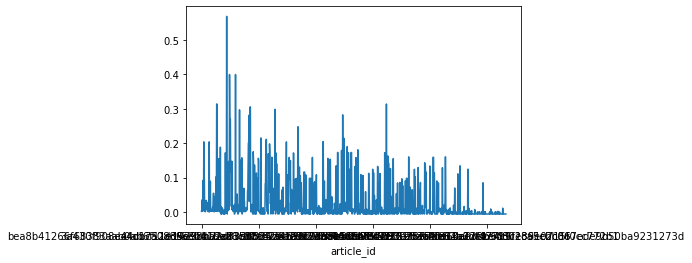

In [72]:

#AVG OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Avg_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_citanti)
    
    #X_normalized = (X - X_min) / (X_max - X_min)
    
    stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Avg_of_hop_avg_dist-min_len)/len_Difference)  
    
    
stima_veridicita_articoli.estimate.plot()    

# NORMALIZZAZIONE FATTA DEFINENDO LE VARIABILI COME LOGARITMI AVENTE BASE = VALORE MASSIMO

In [52]:


stima = []
a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:


#print(article_id)

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])

    if(num_cit_entranti >0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values

        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        communities_citanti = []

        for i in autori_citanti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_citanti.append(j)

        communities_citanti = np.unique(communities_citanti)

        
        Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)

    else:
        AVG_PR_autori_citanti = 0
        Min_of_hop_avg_dist = 0
    
    f = a*(math.log(PR_Max,PR_autore))
    
        
    try:    
        s = b*(math.log(cit_entranti_max,num_cit_entranti))
    except:
        s = 0
        
    try:    
        t = c*(math.log(PR_Max,AVG_PR_autori_citanti))
    except:
        t = 0
        
    try:    
        q = d*(math.log(max_len,Min_of_hop_avg_dist))
    except:
        q = 0
    v = f + s + t + q
    if(v<0):
        print(max_len)
        print(Min_of_hop_avg_dist)
        break
    
    stima_veridicita_articoli.loc[m]['estimate'] = f + s + t + q
   
    

5
0.5


<AxesSubplot:xlabel='article_id'>

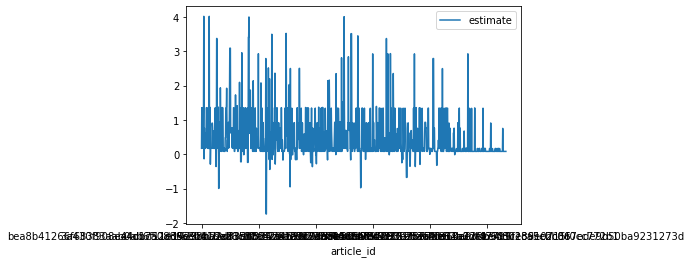

In [50]:
#stima_veridicita_articoli.sort_values(by='estimate').plot()
stima_veridicita_articoli.plot()

In [60]:
# NON VA BENE PERCHE RESTITUISCE VALORI NEGATIVI